# Packages!

In [1]:
# Usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from sklearn.model_selection import train_test_split
# TensorFlow warning suppression
import os
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger('tensorflow').setLevel(logging.FATAL)

params = {'font.size': 18,
          'axes.linewidth':1}
plt.rcParams.update(params)

### Importing Experimental Data (AME2016)
First we read the experimental data into a Pandas dataframe. The Semi-Empirical Mass Formula (**SEMF**) is a liquid drop model - it's more accurate for bigger nuclei with more neutrons and protons. We'll therefore exclude the smaller nuclei from model-fitting and use elements $Z \ge 20$. The cell output shows the first five nuclei in our dataframe.

In [2]:
# Keeping relevant columns from AME2016 dataset 
data = pd.read_csv('EXPERIMENT_AME2016.dat', sep=r'\s+', usecols=['A', 'N', 'Z', 'E', 'E/A'])
data = data.loc[data['Z'] >= 20]
data.head()

,A,N,Z,E,E/A
350,34,14,20,-244.917409,-7.203453
351,35,15,20,-262.026409,-7.486469
352,36,16,20,-281.353053,-7.815363
353,37,17,20,-296.109281,-8.002954
354,38,18,20,-313.103043,-8.239554


### Finding SEMF Parameters
The equations calculate the terms in the formula. The pairing term contains a delta function that is zero when the mass number is odd, and changes sign for odd/even combinations of neutrons and protons. We'll save these to the dataframe to find the model parameters.

In [3]:
# First add coefficients of each term in the formula to the dataset 
data['semf_surface'] = -data['A']**(2/3)
data['semf_coulomb'] = -data['Z']*(data['Z'] -1)/data['A']**(1/3)
data['semf_asymmetry'] = -(data['A'] - 2*data['Z'])**2/data['A']
data['semf_pairing'] = data['A']*0 


# Odd-even delta for pairing term
for i in data.index:
    mass_num = data.loc[i, 'A']
    if mass_num % 2 == 0:
        if data.loc[i, 'Z'] % 2 == 0:
            data.loc[i, 'semf_pairing'] = mass_num**(-0.5)
        elif data.loc[i, 'Z'] % 2 == 1: 
            data.loc[i, 'semf_pairing'] = -mass_num**(-0.5)

data.head()

,A,N,Z,E,E/A,semf_surface,semf_coulomb,semf_asymmetry,semf_pairing
350,34,14,20,-244.917409,-7.203453,-10.495085,-117.298005,-1.058824,0.171499
351,35,15,20,-262.026409,-7.486469,-10.699875,-116.170069,-0.714286,0.000000
352,36,16,20,-281.353053,-7.815363,-10.902724,-115.084304,-0.444444,0.166667
353,37,17,20,-296.109281,-8.002954,-11.103702,-114.038025,-0.243243,0.000000
354,38,18,20,-313.103043,-8.239554,-11.302879,-113.028786,-0.105263,0.162221


### Least Squares Regression to Determine SEMF parameters 
The terms calculated above are the coefficients $\mathbf{A}$ of the SEMF parameters $\vec{x}$, regression will find $\vec{x}$ that approximately solves the equation $\mathbf{A}\vec{x} = y$, where $y$ is the experimental binding energy "E". The obtained values closely match those found in textbooks/online. 

In [17]:
# Convert into coefficient matrix 
coeff = np.asarray([data['A'], data['semf_surface'], data['semf_coulomb'],
    data['semf_asymmetry'], data['semf_pairing']])
# Transpose into columns
coeff = coeff.T
y = data['E']
# Least squares regression to find parameters 
params = np.linalg.lstsq(coeff, y, rcond=None)[0]
# Need parameters as column vector for next step
params = params[:, np.newaxis]
print(params)

[[-15.56054437]
 [-17.20918287]
 [ -0.708507  ]
 [-22.97878903]
 [-12.09663019]]


### Plotting Error
Below is the residuals plot between the fitted SEMF and the experimental data. Notice the sharp error peaks at certain nuclei ("magic numbers" of nucleons); these occur where nuclear shells are closed and stable, a phenomenon not captured in the SEMF model.

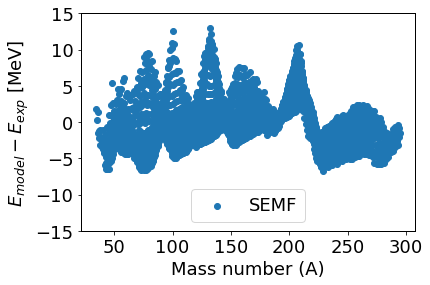

In [24]:
# Add SEMF predictions to dataset, plot comparison 
data['semf_E'] = np.matmul(coeff, params)
# Plot difference between SEMF predictions and experimental values 
plt.scatter(data['A'], (data['semf_E'] - data['E']), label='SEMF')
plt.xlabel('Mass number (A)')
plt.ylabel('$E_{model} - E_{exp}$ [MeV]')
plt.ylim(-15, 15)
plt.legend(loc='lower center')
plt.show()

### Neural Network Fitting
The function below constructs, compiles, and trains a feedforward neural network with two hidden layers. It accepts a dataframe as input with a corresponding features list and single target (binding energy in our case). The layers are densely-connected, and the first layer normalizes the inputs. An early stopping callback will watch the validation loss to end training before overfitting happens. 

In [6]:
# Next, we design our model architecture to be optimized. Going with two hidden layers and ReLU activation.
def dnn_model(df, features, target, hyparms):
    # Splitting into training/testing sets 
    train_set = df.sample(frac=0.8, random_state=0)
    test_set = df.drop(train_set.index)
    x_train = train_set[features]
    y_train = train_set[target]
    # Creating normalizing object
    normalizer = tf.keras.layers.Normalization(axis=-1)
    # Adapting normalizer to inputs 
    normalizer.adapt(np.array(x_train))
    # Specifying model architecture 
    DNN_model = keras.Sequential([
      normalizer,
      layers.Dropout(hyparms[3]),
      layers.Dense(hyparms[1], activation='relu'),
      layers.Dropout(hyparms[3]),
      layers.Dense(hyparms[2], activation='relu'),
      layers.Dropout(hyparms[3]),
      # Regression problem requires only one linear output unit
      layers.Dense(1)])
    # Preventing overtraining with early stopping
    stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True)
    # Loss function for regression, using Adam optimizer
    DNN_model.compile(optimizer='Adam',
              loss=tf.keras.losses.MeanAbsoluteError())
    # Training model 
    history=DNN_model.fit(x_train, y_train,
        batch_size=64,
        epochs=hyparms[0],
        callbacks=[stopping],
        verbose=0,
        validation_split=0.2)
    # Performance metrics during training 
    val_loss_per_epoch = history.history['val_loss']
    # After training, predicting target from features 
    y_prediction = DNN_model.predict(df[features])
    # Returning predicted energies and validation loss for model tuning
    return y_prediction, val_loss_per_epoch

### Tuning Hyperparameters
The cells below will refine the neural network architecture by optimizing the hyperparameters: the number of nodes in the hidden layers, the amount of dropout between layers, and the number of training epochs. The first function quickly tests a configuration and returns the corresponding validation loss. The second cell delineates the domain of each hyperparameter. Hyperopt's Tree Parzen Estimator algorithm will try to minimize the validation loss over 20 evaluations of the neural network. 

In [7]:
# DNN features are same as SEMF 
features = ['A', 'semf_surface', 'semf_coulomb', 'semf_asymmetry', 'semf_pairing']

# Creating function that trial runs the neural network for hyperparameter optimization
def dnn_evaluate(hyparms):
    n_nodes1 = int(hyparms['n_nodes1'])
    n_nodes2 = int(hyparms['n_nodes2'])
    frac_dropout = float(hyparms['frac_dropout'])
    # Optimization will seek to minimize validation loss
    model_loss = dnn_model(data, features, 'E', [30, n_nodes1, n_nodes2, frac_dropout])[1][-1]
    return model_loss 

In [8]:
# Defining hyperparameter space to be explored by optimization

space = {
    'frac_dropout': hp.quniform('frac_dropout', 0, 0.5, 0.1),
    'n_nodes1': hp.quniform('n_nodes1', 50,300,50),
    'n_nodes2': hp.quniform('n_nodes2', 50,300,50),
}

# Results object
trials = Trials()

In [9]:
# Optimizing
besthyparms = fmin(dnn_evaluate, space, algo=tpe.suggest, max_evals=20, trials=trials)

# Print results 
print("Val_loss",trials.best_trial['result']['loss'])
print(besthyparms)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

100%|██████████| 20/20 [01:53<00:00,  5.66s/trial, best loss: 6.458545207977295] 
Val_loss 6.458545207977295
{'frac_dropout': 0.0, 'n_nodes1': 150.0, 'n_nodes2': 150.0}


Now that we have our model architecture, we'll find the optimum amount of training time (the number of epochs before the validation loss plateaus or increases from overfitting). Then, we'll train the model for the prescribed number of epochs and save the neural network predictions to the dataframe.

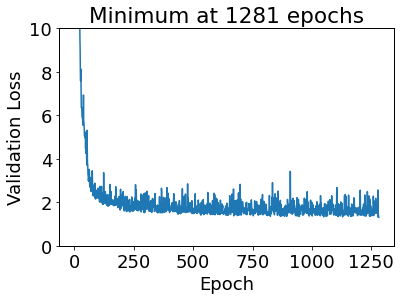

In [10]:
# Recording the best parameters from the optimization
frac_dropout = besthyparms['frac_dropout']
n_nodes1, n_nodes2 = besthyparms['n_nodes1'], besthyparms['n_nodes2']

# Finding best number of training epochs
n_epochs = 2000
losses = dnn_model(data, features, 'E', [n_epochs, n_nodes1, n_nodes2, frac_dropout])[1]
best_epoch = losses.index(min(losses)) + 1

# Plotting loss vs. epoch
plt.plot(np.arange(1, best_epoch+1), losses[:best_epoch])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.ylim(0, 10)
plt.title('Minimum at %3d epochs' % best_epoch)
plt.show()

In [11]:
# Reinstantiating the neural network with the best number of epochs
data['dnn_E'] = dnn_model(data, features, 'E', [best_epoch, n_nodes1, n_nodes2, frac_dropout])[0]

### Results!
As expected, the neural network can better fit the SEMF terms to the experimental masses. This improvement is due to the nonlinearity and much greater number of parameters in the DNN model. The overall mean-squared error is reduced by a factor of ~$\frac{1}{3}$, and the peaks around magic numbers are diminished but still present because SEMF lacks a nuclear shell term. 

SEMF mean-squared error = 10.01 MeV^2, DNN mean-squared error = 3.50 MeV^2


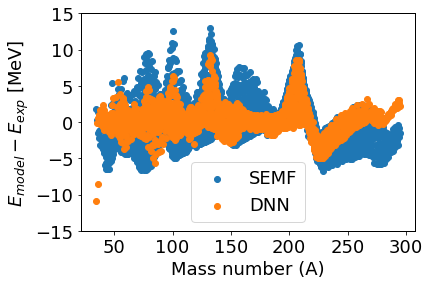

In [25]:
# Calculating mean-squared error in mass predictions for both SEMF and neural network
SEMF_err = data['semf_E'] - data['E']
SEMF_mse = np.sum(SEMF_err**2)/len(data.index)
DNN_err = data['dnn_E'] - data['E']
DNN_mse = np.sum(DNN_err**2)/len(data.index)
print('SEMF mean-squared error = %2.2f MeV^2, DNN mean-squared error = %2.2f MeV^2' % (SEMF_mse, DNN_mse))

# Comparing results
plt.scatter(data['A'], SEMF_err, label='SEMF')
plt.scatter(data['A'], DNN_err, label='DNN')
plt.xlabel('Mass number (A)')
plt.ylim(-15, 15)
plt.ylabel('$E_{model} - E_{exp}$ [MeV]')
plt.legend(loc='lower center')
plt.show()